In [25]:
import os
import sys
import numpy as np
import random
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Functions Def

In [26]:
def get_axes(L, max_col=3):
    cols = L if L <= max_col else max_col
    rows = int(L / max_col) + int(L % max_col != 0)
    fig, ax = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), dpi=100)
    ax =  ax.flatten()
    return fig, ax

def shuffle(X, Y=None, n=None):
    l = np.arange(X.shape[0])
    random.shuffle(l)
    if Y is None:
        return X[l[:n],:]
    elif Y is None and n is None:
        return X[l,:]
    elif n is None:
        return X[l,:], Y[l]
    else: 
        return X[l[:n],:], Y[l[:n]]
    
def get_rnd_sample(data, N, ):
    return shuffle(data, Y=None, n=int(data.shape[0]/N))


## File Path and other name variables

In [27]:
MODE = 'BOTH' # WHOLE or INDIVIDUAL or BOTH method
PCA_DIM = 5

In [28]:
SYS_NAME_DIR = 'SYS-A/'
SUB_DIR = '200mol/rcut40/'
SUB_PCA = 'pca_files/'
SUB_SOAP = 'soap_files/'
SYS_PCA_DIR = SYS_NAME_DIR + SUB_PCA
SYS_SOAP_DIR = SYS_NAME_DIR + SUB_SOAP 

In [29]:
if os.path.exists(SYS_PCA_DIR):
    print(f"Folder already exist!\n{SYS_PCA_DIR}")
if not os.path.exists(SYS_PCA_DIR):
    os.makedirs(SYS_PCA_DIR)
    print(f"Created folder\n{SYS_PCA_DIR}")

Folder already exist!
SYS-A/pca_files/


In [30]:
FILES = []
for entry in os.listdir(SYS_SOAP_DIR):
    if os.path.isfile(os.path.join(SYS_SOAP_DIR, entry)):
        if entry.endswith('.npy'):
            FILES.append(entry)

print(SYS_SOAP_DIR)
FILES = sorted(FILES)
print(f"SOAP files {len(FILES)}:\n{FILES}")

SYS-A/soap_files/
SOAP files 3:
['SOAP_200mol_rcut40_trj0-3000-10.npy', 'SOAP_310mol_rcut40_trj0-2000-10.npy', 'SOAP_400mol_rcut40_trj0-2000-10.npy']


In [31]:
SOAP_FILES = {'sys_'+str(num): np.load(SYS_SOAP_DIR+soap) for num,soap in enumerate(FILES)}
SOAP_FILES.keys()

dict_keys(['sys_0', 'sys_1', 'sys_2'])

In [32]:
for s in SOAP_FILES:
    print(SOAP_FILES[s].shape)

(300, 200, 324)
(200, 310, 324)
(200, 400, 324)


In [33]:
for k in SOAP_FILES:
    SOAP_FILES[k] = np.vstack(SOAP_FILES[k])
    print(SOAP_FILES[k].shape)

(60000, 324)
(62000, 324)
(80000, 324)


## Output

In [34]:
import datetime
import json

today = datetime.datetime.now().strftime("%b-%d-%Y-%H-%M")
fname_output = f"pca.output_{today}"

with open(SYS_PCA_DIR+fname_output, 'w') as file:
    file.write("\n# -----------------------------\n")
    file.write(f"Mode selected: {MODE}\n")
    file.write(f"SOAP files dir: {SYS_SOAP_DIR}\n")
    for n,p in enumerate(SOAP_FILES):
        file.write(f"\t{p}: {FILES[n]}\n")

## PCA dim reduction

(202000, 324)


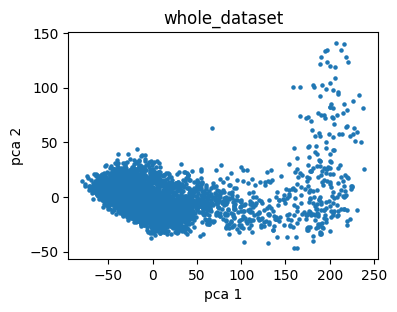

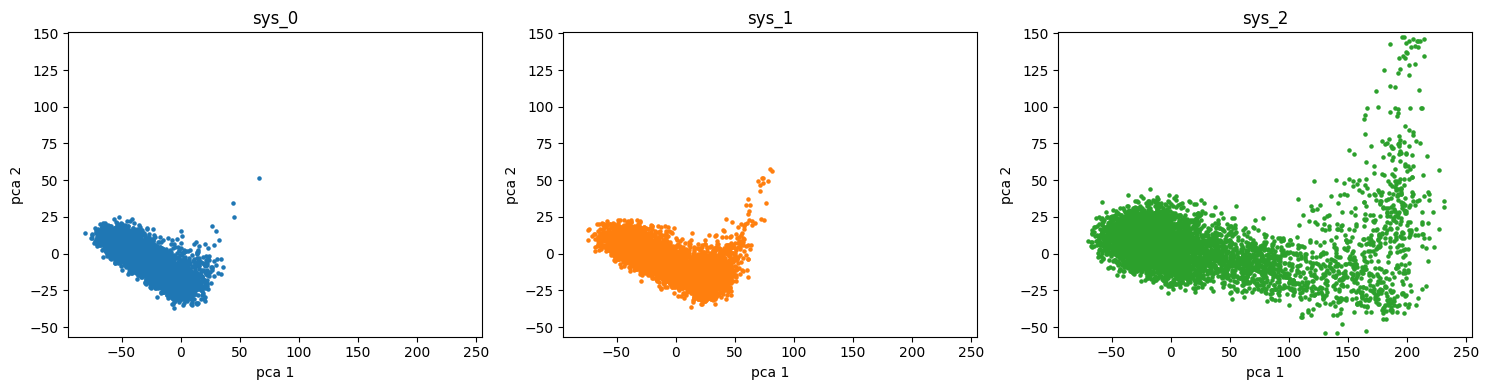

In [35]:
if 'WHOLE' in MODE or 'BOTH' in MODE:
    
    with open(SYS_PCA_DIR+fname_output, 'a') as file:
        file.write("\n# -----------------------------\n")
        file.write(f"Selected mode: {MODE} (Whole Section)\n")

        # ----------------------------------------------
        # compute the pca dim red on the whole data set
        # and then use the model to transfor individuals
        ALL_DATA = [get_rnd_sample(SOAP_FILES[soap_data], 1) for soap_data in SOAP_FILES]
        ALL_DATA = np.vstack(ALL_DATA)
        ALL_DATA = np.vstack(ALL_DATA)
        print(ALL_DATA.shape)
        file.write(f"Whole data set shape: {ALL_DATA.shape}\n")

        file.write(f"Fitting PCA model with DIM={PCA_DIM}\n")
        pca = PCA(PCA_DIM)
        ALLPCA = pca.fit_transform(ALL_DATA)

        variance = pca.explained_variance_ratio_
        var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
        file.write(f"Whole systems PCA (dim={PCA_DIM}) variance: {var}\n")

        np.savetxt(SYS_PCA_DIR+'wholesystem.pca', ALLPCA)

        # ----------------------------------------------
        # plot the result of the whole data set
        np.random.shuffle(ALLPCA)   
        fig, ax = plt.subplots(figsize=(4, 3), dpi=100)
        ax.scatter(ALLPCA[:5000,0], ALLPCA[:5000,1], s=5)
        ax.set_title('whole_dataset')
        ax.set_xlabel('pca 1')
        ax.set_ylabel('pca 2')
        gx = ax.get_xlim()
        gy = ax.get_ylim()
        plt.savefig(SYS_PCA_DIR+"whole.png")

        # ----------------------------------------------
        # storing and saving data
        PCA_FILES = {'sys_'+str(num): pca.transform(SOAP_FILES[syspca]) for num,syspca in enumerate(SOAP_FILES)}
        file.write(f"Saving data in \n{SYS_PCA_DIR}\n")
        for i,sys in enumerate(PCA_FILES):
            np.savetxt(SYS_PCA_DIR+'PCA'+FILES[i][4:-4]+'.pca', PCA_FILES[sys])

        # ----------------------------------------------
        # plot the results of individuals
        L=len(PCA_FILES)
        CLRS = sns.color_palette('tab10', L)

        if L == 1:
        
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=100)
            for i,sys in enumerate(PCA_FILES):
                ax.scatter(PCA_FILES[sys][:5000,0], PCA_FILES[sys][:5000,1], s=1, color=CLRS[i])
                ax.set_title(sys)
                ax.set_xlabel('pca 1')
                ax.set_ylabel('pca 2')
                ax.set_xlim(gx)
                ax.set_ylim(gy)
            fig.tight_layout()
            plt.savefig(SYS_PCA_DIR+"systemPCA_formwhole.png")
        
        else:
        
            fig, ax = get_axes(L, max_col=L)
            for i,sys in enumerate(PCA_FILES):
                ax[i].scatter(PCA_FILES[sys][:5000,0], PCA_FILES[sys][:5000,1], s=5, color=CLRS[i])
                ax[i].set_title(sys)
                ax[i].set_xlabel('pca 1')
                ax[i].set_ylabel('pca 2')
                ax[i].set_xlim(gx)
                ax[i].set_ylim(gy)
            fig.tight_layout()
            plt.savefig(SYS_PCA_DIR+"systemPCA_formwhole.png")
        

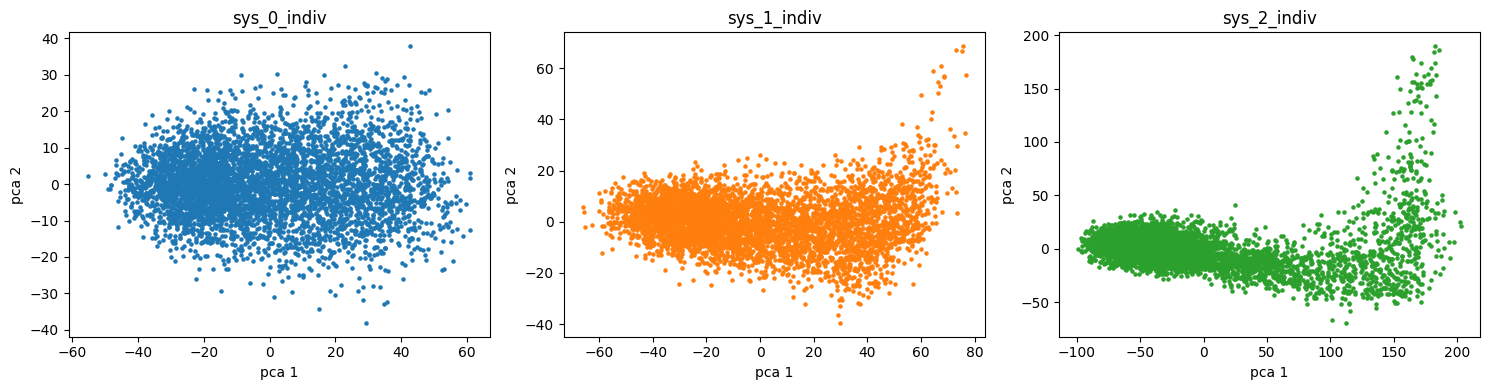

In [36]:
if 'INDIVIDUAL' in MODE or 'BOTH' in MODE:
    
    with open(SYS_PCA_DIR+fname_output, 'a') as file:
        file.write("\n# -----------------------------\n")
        file.write(f"Selected mode: {MODE} (Individual Section)\n")
    
        # ----------------------------------------------
        # compute the PCA dim red on individuals data set
        file.write(f"Fitting PCA model with DIM={PCA_DIM}\n")
        
        pca = PCA(PCA_DIM)
        PCA_FILES = {'sys_'+str(num): pca.fit_transform(SOAP_FILES[syspca]) for num,syspca in enumerate(SOAP_FILES)}
        
        # ----------------------------------------------
        # storing and saving data
        file.write(f"Saving data in \n{SYS_PCA_DIR}")
        for i,sys in enumerate(PCA_FILES):
            np.savetxt(SYS_PCA_DIR+'PCA'+FILES[i][4:-4]+'_INDIVIDUAL.pca', PCA_FILES[sys])

        # ----------------------------------------------
        # plot the results of individuals
        L=len(PCA_FILES)
        CLRS = sns.color_palette('tab10', L)
        
        if L == 1:
        
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=100)
            for i,sys in enumerate(PCA_FILES):
                ax.scatter(PCA_FILES[sys][:5000,0], PCA_FILES[sys][:5000,1], s=5, color=CLRS[i])
                ax.set_title(sys+'_indiv')
                ax.set_xlabel('pca 1')
                ax.set_ylabel('pca 2')
            fig.tight_layout()
            plt.savefig(SYS_PCA_DIR+"systemPCA_individual.png")
        
        else:
        
            fig, ax = get_axes(L, max_col=L)
            for i,sys in enumerate(PCA_FILES):
                ax[i].scatter(PCA_FILES[sys][:5000,0], PCA_FILES[sys][:5000,1], s=5, color=CLRS[i])
                ax[i].set_title(sys+'_indiv')
                ax[i].set_xlabel('pca 1')
                ax[i].set_ylabel('pca 2')
            fig.tight_layout()
            plt.savefig(SYS_PCA_DIR+"systemPCA_individual.png")